# 串接chatgpt api
- 官方文件：https://platform.openai.com/docs/guides/text-generation/chat-completions-api
- 範例：https://cookbook.openai.com/examples/how_to_format_inputs_to_chatgpt_models

# 計算token
- token計算機：https://platform.openai.com/tokenizer
- tiktoken套件：https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken
- 新帳號有18美元額度可以使用，期限三個月，過期或是使用完畢後，就必須付費使用。
    - 一個中文字約等於3/4個token
    - 1000個token需要0.02美元(以GPT-3.5 Turbo的輸出額度計算)
    - 18美元可以有900000個token，約等於1200000個中文字(輸入+輸出)

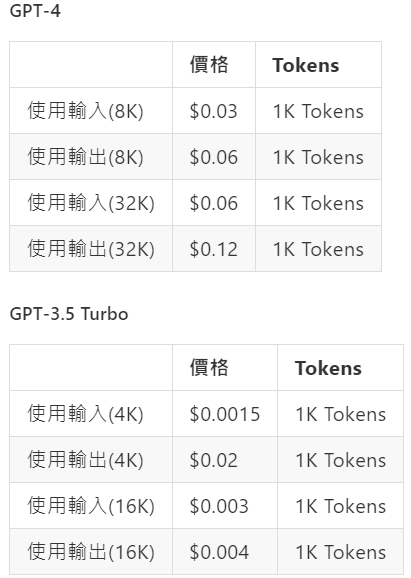

# function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 取得情緒情境
def get_situation(mood: str) -> str:
    client = OpenAI(api_key=api_key)
    completion = client.chat.completions.create(
        model = "gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "你現在是一名使用繁體中文的台灣人，會使用精確的台灣用語，且口吻自然不制式。"},
            {"role": "user", "content": f"幫我生成20個{mood}情緒的情境，要遵守以下規則：任何事件皆可以、簡單{mood}的事件也可以。"},
            ],
        temperature = 0.7,
        frequency_penalty = 1, # 控制詞彙出現頻率，提高可增加詞彙多樣性，避免特定詞彙一直出現
        presence_penalty = 1, # 控制文本中是否存在特定詞彙或短語，increasing the model's likelihood to talk about new topics
    )
    situation = completion.choices[0].message.content
    return situation

In [ ]:
# 取得日記文本、情緒、字數(new)
import random
def get_text_plus(mood: str, situation: str, num: int) -> list:
    client = OpenAI(api_key=my_api_key)
    completion = client.chat.completions.create(
        model = "gpt-3.5-turbo",
        messages=[
        {"role": "system", "content": f"你現在是一名使用繁體中文的台灣人，會使用精確的台灣用語，且口吻不制式、隨意。"},
        {"role": "user", "content": f"幫我生成20個會{mood}的情境，要遵守以下規則：任何事件皆可以、簡單{mood}的事件也可以。"},
        {"role": "assistant", "content": situation},
        {"role": "user", "content": f"以當事者的角度用第{num}個情境寫1篇{mood}主題的個人日記，要遵守以下規則：內容不需要振作、開頭不要帶有情緒、不要有日期、英文、空格、換行等符號，字數限制200到300字之間。"},
        ],
        temperature = 0.7, # (0~1, default 0)控制輸出隨機生成，越高越隨機
        frequency_penalty = round(random.uniform(0.6, 1), 2), # (-2~2, default 0)控制詞彙出現頻率，提高可增加詞彙多樣性，避免特定詞彙一直出現
        presence_penalty = round(random.uniform(0.6, 1), 2), # (-2~2, default 0)控制文本中是否存在特定詞彙或短語，increasing the model's likelihood to talk about new topics
        # max_tokens = 225
    )
    text = completion.choices[0].message.content
    text = text.strip('\n')
    length = len(text)
    length = str(length)
    finish = completion.choices[0].finish_reason
    return [text, mood, length, finish]

In [ ]:
# 取得token數
def get_num_tokens(string: str) -> list:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    num_tokens = len(encoding.encode(string))
    num_tokens = str(num_tokens)
    return num_tokens

In [ ]:
!pip install openai
!pip install tiktoken

In [ ]:
%cd /content/drive/MyDrive
%ls

In [ ]:
# main
"""
4個顏色共320篇
每個顏色80篇
顏色再分為4種情緒
每種情緒20篇(文章長度200~300字)
"""

from openai import OpenAI
import tiktoken
import csv
import time

if __name__ == "__main__":
    with open('openai_api_key.txt', 'r') as file:
        my_api_key = file.read().strip('\n').strip()

    group = {'藍色': ['傷心', '疲倦', '厭煩', '失落',],
              '綠色': ['平靜', '開心', '專注', '舒適',],
              '黃色': ['憂鬱', '緊張', '沮喪', '困惑',],
              '紅色': ['生氣', '害怕', '恐慌', '焦慮',]}

    color = '紅色'
    mood = group[color][3]


    # for loop(隨機選取情緒)
    for i in range(5):
        outputs = []
        situation = get_situation(mood) # call get_situation function
        output = get_text_plus(mood, situation, num=i) # call get_text_new function
        text = output[0]
        num_tokens = get_num_tokens(text) # call get_num_tokens function

        outputs.extend(output)
        outputs.append(num_tokens)
        outputs.append(color)

        # 存檔.csv (欄位：text、mood、length、finish_reason、num_tokens、color)
        with open('data_test.csv', mode='a', newline='', encoding='utf-8') as file:
            csv_file = csv.writer(file)
            csv_file.writerow(outputs)

        time.sleep(60)